In [2]:
import sys
import os

# Get the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add project root to python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Add src folder to python path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print("Project root:", project_root)
print("Src path:", src_path)


Project root: c:\Users\harsh\LangChain\energy-forecasting
Src path: c:\Users\harsh\LangChain\energy-forecasting\src


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocessing import load_energy_data,clean_and_resample,train_test_split
from src.model_sarima import find_best_sarima_params,train_sarima_model,forecast_future
from src.utils import plot_forecast


In [4]:
df = load_energy_data("../data/PJME_hourly.csv")
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


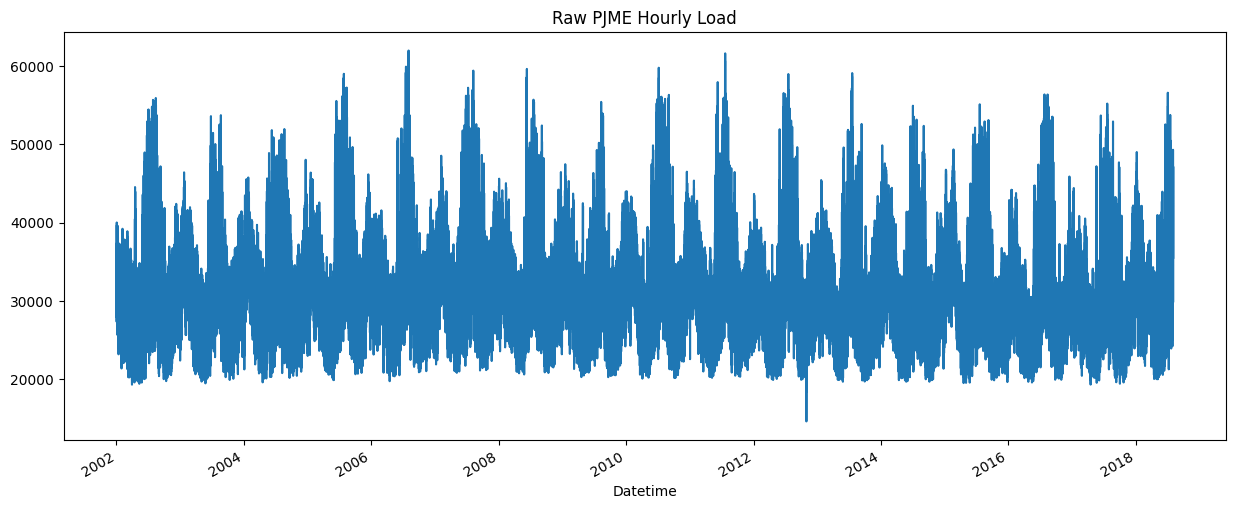

             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000
PJME_MW    0
dtype: int64


In [5]:
df["PJME_MW"].plot(figsize=(15,6),title="Raw PJME Hourly Load")
plt.show()

print(df.describe())
print(df.isna().sum())

<Axes: title={'center': 'Daily PJME Load'}, xlabel='Datetime'>

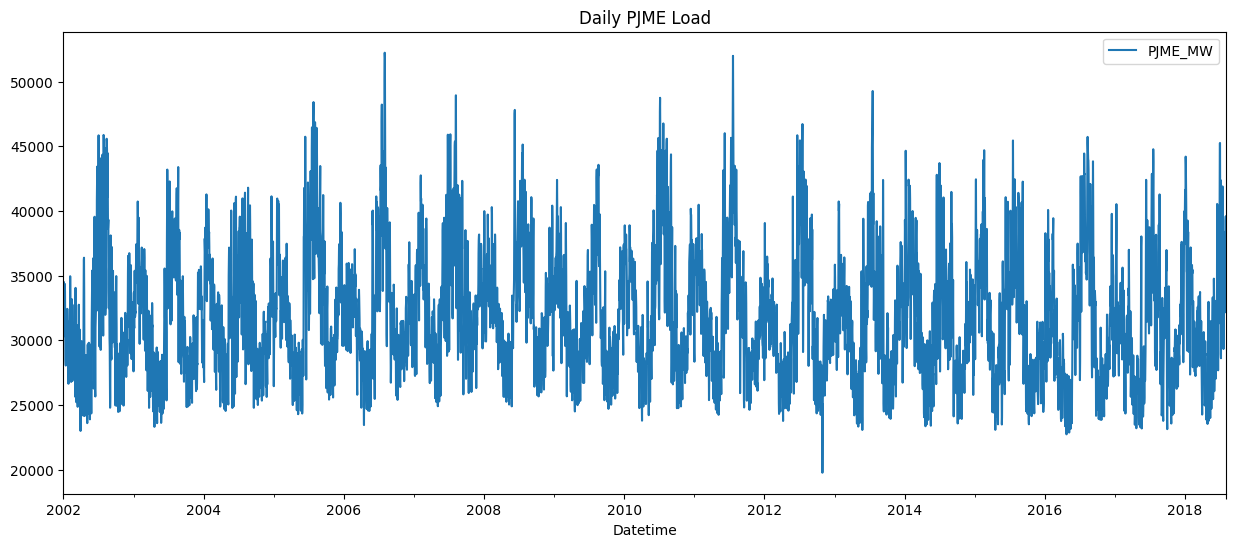

In [6]:
daily_df = clean_and_resample(df)
daily_df.plot(figsize=(15,6),title="Daily PJME Load")


In [7]:
train, test = train_test_split(daily_df,30)
print(train.shape,test.shape)

(6029, 1) (30, 1)


In [8]:
order,seasonal_order = find_best_sarima_params(train["PJME_MW"],seasonal_period=7)

print("Best order:",order)
print("Best seasonal order:",seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=10.59 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=111300.268, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=110024.150, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=110149.564, Time=2.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=111298.270, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=111134.086, Time=0.23 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=109344.648, Time=4.15 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=13.00 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=9.03 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=109549.471, Time=3.49 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=108819.522, Time=6.38 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=109399.720, Time=1.01 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=17.10 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=8.48 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   :

In [16]:
order=(1,1,3)
seasonal_order=(2,0,0,7)
model_fit = train_sarima_model(train['PJME_MW'],order,seasonal_order)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            PJME_MW   No. Observations:                 6029
Model:             SARIMAX(1, 1, 3)x(2, 0, [], 7)   Log Likelihood              -53957.771
Date:                            Wed, 07 Jan 2026   AIC                         107929.541
Time:                                    21:59:49   BIC                         107976.453
Sample:                                01-01-2002   HQIC                        107945.830
                                     - 07-04-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5675      0.021     26.996      0.000       0.526       0.609
ma.L1         -0.4462      0.024    -18.947      0.000      -0.492      -0.400
ma.L2         -0.4290      0.012    -36.856      0.000      -0.452      -0.406
ma.L3         -0.0611      0.018     -3.349      0.001      -0.097      -0.025
ar.S.L7        0.3087      0.011     28.143      0.000       0.287       0.330
ar.S.L14       0.2844      0.011     25.619      0.000       0.263       0.306
sigma2      3.645e+06   5.23e+04     69.719      0.000    3.54e+06    3.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               435.11
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
forecast = forecast_future(model_fit,steps=30)
forecast

2018-07-05    38592.173573
2018-07-06    37156.329539
2018-07-07    35579.309289
2018-07-08    37194.851903
2018-07-09    38981.313042
2018-07-10    38430.847222
2018-07-11    36528.138803
2018-07-12    37765.014934
2018-07-13    37869.739528
2018-07-14    37244.418243
2018-07-15    38355.862712
2018-07-16    40222.686916
2018-07-17    40062.717675
2018-07-18    37880.372997
2018-07-19    37960.150392
2018-07-20    37583.874909
2018-07-21    36942.170000
2018-07-22    37744.688092
2018-07-23    38829.059495
2018-07-24    38623.092899
2018-07-25    37408.189027
2018-07-26    37784.579321
2018-07-27    37698.190581
2018-07-28    37322.231835
2018-07-29    37886.088277
2018-07-30    38751.792985
2018-07-31    38642.708861
2018-08-01    37646.969250
2018-08-02    37785.861083
2018-08-03    37652.176969
Freq: D, Name: predicted_mean, dtype: float64

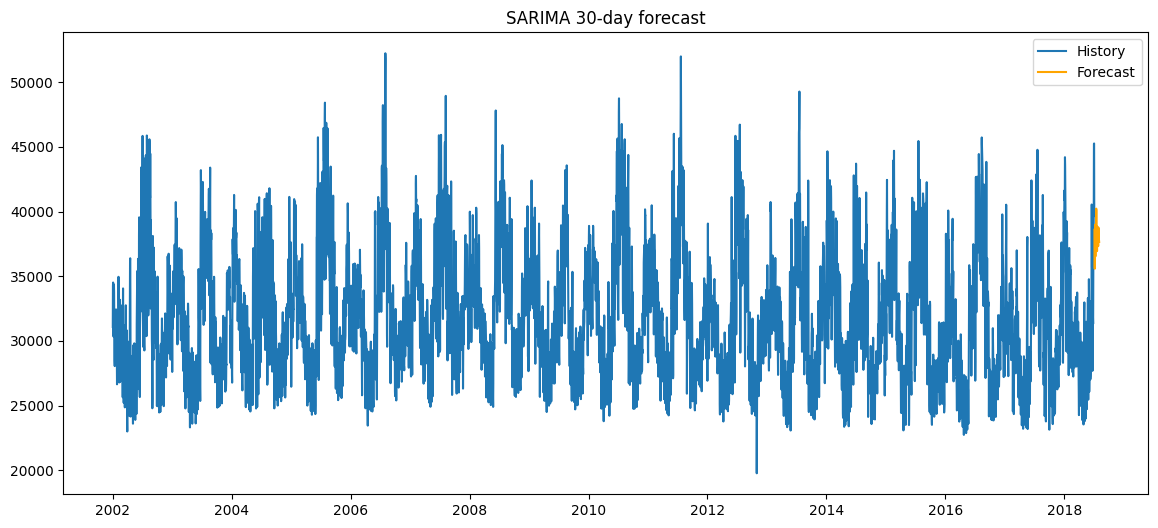

In [12]:
plot_forecast(train["PJME_MW"],forecast,title="SARIMA 30-day forecast")

In [13]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

mse = mean_squared_error(test,forecast)
mae = mean_absolute_error(test,forecast)
rmse = mse**0.5
print("MSE:",mse)
print("MAE:",mae)

MSE: 14172855.089064073
MAE: 2992.3093030418154


In [14]:
forecast.to_csv("forecast_output.csv")

In [17]:
model_fit.save("sarima_model.pkl")

In [18]:
import json

metadata={
    "order":order,
    "seasonal_order":seasonal_order,
    "last_trained":str(train.index[-1])
}

with open("metadata.json","w") as f:
    json.dump(metadata,f,indent=4)